In [1]:
import pandas as pd
import matplotlib.pylab as plt
from scipy.stats import shapiro
from scipy import stats

In [2]:
df = pd.read_csv('data/4000_complete_data.csv')

In [3]:
df.head()

,rank,lemma,PoS,freq,synonym,synset,random,synonym_similarity_left,synonym_similarity_right,synonym_similarity,random_similarity_left,random_similarity_right,random_similarity
0,26,say,v,4096416,tell,Synset('order.v.01'),blanket,0.792683,0.785402,0.789042,0.612346,0.621714,0.617030
1,31,go,v,3546732,start,Synset('start.v.09'),blank,0.718980,0.710389,0.714685,0.592116,0.595401,0.593759
2,34,get,v,3347615,acquire,Synset('get.v.01'),overhaul,0.764049,0.767176,0.765613,0.672227,0.664227,0.668227
3,39,know,v,2761628,recognise,Synset('acknowledge.v.06'),chisel,0.762813,0.771491,0.767152,0.694732,0.695436,0.695084
4,50,make,v,2290830,get,Synset('make.v.02'),tickle,0.758087,0.768161,0.763124,0.678154,0.688789,0.683472


In [4]:
df["synonym_similarity"] = (df["synonym_similarity_left"] + df["synonym_similarity_right"]) / 2
df["random_similarity"] = (df["random_similarity_left"] + df["random_similarity_right"]) / 2
eda_df = pd.concat([df['PoS'], df["synonym_similarity"], df["random_similarity"]], axis=1)

In [5]:
eda_df.head()

,PoS,synonym_similarity,random_similarity
0,v,0.789042,0.617030
1,v,0.714685,0.593759
2,v,0.765613,0.668227
3,v,0.767152,0.695084
4,v,0.763124,0.683472


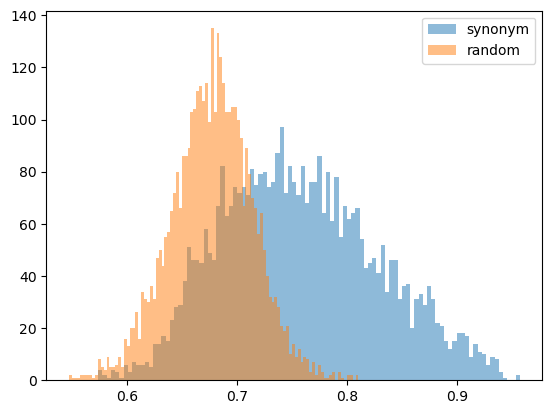

In [6]:
plt.hist(df["synonym_similarity"], bins = 100, alpha = 0.5, label="synonym")
plt.hist(df["random_similarity"], bins = 100, alpha = 0.5, label="random")
plt.legend()
plt.show()

### Hypothesis testing to discover the difference

In [7]:
# Check normality of two groups
shapiro_test_syn = shapiro(df["synonym_similarity"])
shapiro_test_rand = shapiro(df["random_similarity"])
print(shapiro_test_syn, shapiro_test_rand)

ShapiroResult(statistic=0.9901533722877502, pvalue=5.10387325664604e-16) ShapiroResult(statistic=0.9982354044914246, pvalue=0.00019567761046346277)


Two groups are not normally distributed, and the groups are independent. Use U-test to test if GPT has higher similarity on synonym than random pairs.

H0: Synonym pairs have equal similarity as random pairs.<br>
Ha: Synonym pairs have higher similarity than random pairs.

In [8]:
u_statistic, p_value = stats.mannwhitneyu(df["synonym_similarity"], df["random_similarity"], \
                                          alternative='greater')
print(u_statistic, p_value)

13271956.5 0.0


Test result is significant. We reject the null hypothesis, showing synonym pairs have higher similarity than random pairs.

### Difference between pairs' similarities group by PoS

In [9]:
df['PoS'].value_counts()

PoS
n    2231
v     900
a     639
r     212
Name: count, dtype: int64

We have different PoS group sizes in Synonym and Random pairs.

#### Difference between similarities group by PoS (Synonym pairs)

In [10]:
# Check normality
shapiro_test_syn_n = shapiro(eda_df[eda_df['PoS'] == 'n']["synonym_similarity"])
print(shapiro_test_syn_n)

ShapiroResult(statistic=0.9913840293884277, pvalue=3.019094418910129e-10)


Violate normality. Use Kruskal-Wallis test.

H0: In synonym pairs, there is no difference of similarity across PoS.<br>
Ha: There are differences.

In [11]:
from scipy.stats import kruskal

grouped_syn = [eda_df[eda_df['PoS'] == pos]['synonym_similarity'] for pos in eda_df['PoS'].unique()]
h_statistic, p_value = kruskal(*grouped_syn)

print(h_statistic, p_value)

72.40530599280669 1.3034409000510606e-15


P-value smaller than 0.05. Reject the null. There are differences.<br><br>
Let's find out which groups are different.

In [13]:
import scikit_posthocs as sp

dunn_test_results = sp.posthoc_dunn(eda_df, val_col='synonym_similarity', group_col='PoS', p_adjust='bonferroni')

print(dunn_test_results)

              a             n             r             v
a  1.000000e+00  1.000000e+00  1.975867e-01  8.377589e-09
n  1.000000e+00  1.000000e+00  3.795940e-02  2.592166e-12
r  1.975867e-01  3.795940e-02  1.000000e+00  1.589827e-09
v  8.377589e-09  2.592166e-12  1.589827e-09  1.000000e+00


There are differences in (a vs v), (n vs r), (n vs v), (r vs v).

Since the Kruskal-Wallis and Dunn’s tests are non-parametric tests based on ranks, we want to look at median similarities for each PoS.

In [16]:
median_similarity_syn = eda_df.groupby('PoS')['synonym_similarity'].median().sort_values(ascending=False)
median_similarity_syn

PoS
r    0.767477
n    0.757765
a    0.754154
v    0.735873
Name: synonym_similarity, dtype: float64

Results show that r (adverbs) has the highest median similarity, followed by n (nouns), a (adjectives), and v (verbs). It indicates that when scoring similarity in synonym word pairs, GPT would give adverbs with higher scores and verbs with lower ones.